<a href="https://colab.research.google.com/github/chunlam-chan/quantum-coding-samples/blob/main/phases_in_qsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methods for Determining the Phases in QSP

In the previous [notebook](https://github.com/chunlam-chan/quantum-coding-samples/blob/main/qaoa_part1.ipynb), we explored an optimization problem and have seen that the problem can be formulated as finding the ground state of a target Hamiltonian. QAOA can be viewed as a specific algorithm for Hamiltonian simulation, derived from trotterization, with a primary fouus on optimization problems. A broader paradigm in quantum computing that encompasses various techniques for efficient Hamiltonian simulation is known as quantum signal processing (QSP) and its generalization called quantum singular value transform (QSVT).

It is interesting that the fundamental challenge in both QAOA and QSP revolves around finding the optimal phases for some kinds of parameterized circuits. Following this [PennyLane demo](https://pennylane.ai/qml/demos/tutorial_intro_qsvt), once we have found the optimal phases that fit a polynomial function, we can employ the QSVT operation integrated in PennyLane to transform a block encoded matrix. However, the demo did not elucidate how these phases can be derived. Therefore, this notebook engages in a hands-on exercise aimed at uncovering these phases; additionally, it includes a brief reference note summarizing the methods available for this purpose thus far.

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

## QSP and the GSLW's method for determining the phases

Following the notation in [[1, Chapter 7]](#[1]), let us describe QSP as follows. We start with a scalar $x \in [-1, 1]$, which has a one-qubit Hermitian block encoding represented by the matrix $$U_A(x) = \begin{bmatrix} x & \sqrt{1-x^2} \\ \sqrt{1-x^2} & -x \end{bmatrix}.$$ This matrix when combined with a Puali Z operator yields a rotation matrix $$O(x) = U_A(x) Z = \begin{bmatrix} x & -\sqrt{1-x^2} \\ \sqrt{1-x^2} & x \end{bmatrix}.$$ Now, let us explore what kind of quantum state can be expressed when we interleave two types of rotations, $O(x)$ and the Rz rotation. The answer is known as QSP, which says that there exists a set of phase factors $\Phi:= (\phi_0, \cdots, \phi_d) \in [-\pi, \pi]^{d+1}$ such that
$$U_{\Phi}(x) = e^{i\phi_0 Z} \prod_{j=1}^{d} \left [ O(x) e^{i \phi_j Z}\right ] = \begin{bmatrix} P(x) & -Q(x) \sqrt{1-x^2} \\ Q^*(x) \sqrt{1-x^2} & P^*(x) \end{bmatrix}$$
if and only if $P, Q \in \mathbb{C}[x]$ satsify the following conditions:

1. deg$(P) \leq d$, deg$(Q) \leq d-1$ (deg$(Q)=-1$ means $Q=0$),
2. $P$ has parity $d$ mod 2 and $Q$ has parity $d-1$ mod 2, and
3. $|P(x)|^2 + (1-x^2) |Q(x)|^2 = 1, \forall x \in [-1, 1]$.

For problems involving eigenvalue transformation, it is often possible to decompose the transformation into a set of polynomials suitable for QSP. To identify the polynomial $P(x)$ for typical problems such as matrix inverse, Hamiltonian simulation and Gibbs states, a helpful tutorial page is available in this [GitBook](https://qsppack.gitbook.io/qsppack/).

Now, assuming we have a target polynomial $P(x)$ and the operator $U_A(x)$ is available, if we want to construct a quantum circuit for encoding $P(x)$, one approach is to determine a suitable $Q(x)$ and then recursively calculate the phases $\Phi$ based on the method in the proof of QSP [[2, Theorem 3]](#[2]).

This leads to the second question: how do we decide on $Q(x)$? According to [[2, Theorem 4]](#[2]), if $P$ satisfies
4. $\forall x \in [-1, 1]: \vert P(x) \vert \leq 1$,
5. $\forall x \in (-\infty, -1] \cup [1, \infty): \vert P(x) \vert \geq 1$,
6. if $d$ is even, then $\forall x \in \mathbb{R}: P(ix) P^*(ix) \geq 1$

in addition to the above conditions 1 and 2, then there exists an explicit construction of $Q$ based on root finding that satisfies properties 1 to 3. These two theorems in [[2]](#[2]) provide the first constructive method for determining the phases for $U_{\Phi}(x)$. We shall call it the GSLW's method.

Our objective here is to gain a better understanding of this [PennyLane demo](https://pennylane.ai/qml/demos/tutorial_intro_qsvt). Therefore, let's consider the example therein where $P(x) = \frac{1}{2} (5x^3 - 3x)$ is a Legendre polynomial. Such $P(x)$ falls within the scope of the aforementioned theorems.

In [ ]:
try:
    import pennylane as qml
except ImportError as e:
    # Install pennylane if package is not already installed
    !pip install pennylane
    import pennylane as qml
import numpy as np
import numpy.polynomial as npp
from scipy import linalg
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 25.8 MB/s eta 0:00:00


In [ ]:
P_coef = [0, -1.5, 0, 2.5]

P = npp.Polynomial(P_coef)

print(P)

0.0 - 1.5·x¹ + 0.0·x² + 2.5·x³


Now, we explicate the GSLW's method.

#### 1. Completion
- To determine $Q(x)$, Condition 3 motivates us to consider $A(x) := 1 - P(x) P^*(x)$. After some anslysis, it can be shown that $A(x) = K^2(1-x^2) \prod_{s \in \mathcal{S}} (x^2-s)(x^2-s^*)$ for some $K \in \mathbb{R}$. Here, $\mathcal{S} \subseteq \mathbb{C}$ represents a multiset of roots. Once we have found $\mathcal{S}$, we can then choose $Q(x) = K \prod_{s \in \mathcal{S}} (x^2 - s)$ so that $Q$ fulfills the conditions 1 to 3.


#### 2. Decomposition
- If $\deg(P) > 0$, the concerning polynomials should have the form $P(x) = \sum_{k=0}^{l} \alpha_k x^k$ and $Q(x) = \sum_{k=0}^{l-1} \beta_k x^k$ with $|\alpha_l| = |\beta_{l-1}|$. Therefore, the angles $\Phi$ can be constructed recursively as follows:

  1. Set $t = d$
  
  2. While $\deg(P) > 0$:
    - Choose $\phi_t \in [-\pi, \pi]$ so that $e^{2i\phi} = \frac{\alpha_l}{\beta_{l-1}}$, the ratio of coefficients in the leading terms.
    - Reduce $P, Q$ to $\tilde{P}, \tilde{Q}$ such that $\deg(\tilde{P}) = \deg(P) - 1$, $\deg(\tilde{Q}) = \deg(Q) - 1$ and the leading coefficients of $\tilde{P}$ and $\tilde{Q}$ have the same absolute value. The update equations are given by $\tilde{P}(x) = e^{-i \phi} x P(x) + (1-x^2) Q(x) e^{i \phi}$ and $\tilde{Q}(x) = - e^{-i \phi} P(x) + x Q(x) e^{i \phi}$
    - Set $t$ to $t-1$.

  4. Choose $\phi_0$ such that $e^{i \phi_0} = P(1)$.

  5. If $t \geq 2$, set $\phi_j = \frac{\pi}{2}$ for $j=1, 3, \dots, t-1$ and $\phi_{j'} = - \frac{\pi}{2}$ for $j'=2, 4, \dots, t$.

For simplicity, we consider $l = d$ in the implementation below.

In [ ]:
# Construct $A_{\tilde(x)} = A(\sqrt(x))$
A = 1 - P * npp.Polynomial(P.coef.conj())
A_tilde = npp.Polynomial(A.coef[::2])
A_tilde_roots = A_tilde.roots()
list_S = A_tilde_roots[A_tilde_roots.imag > 1e-5]
K = np.sqrt(-A_tilde.coef[-1])

# Find Q(x)
Q = npp.Polynomial(K)
for s in list_S:
  Q *= npp.Polynomial([-s, 0, 1])

print(f'Q(x) = {Q}')

Q(x) = (-0.25000000000000017-0.9682458365518545j) + 0j·x¹ + (2.5+0j)·x²


As a checkpoint for Step 1, we can verify if the polynomials $P, Q$ satisfy Condition 3.

In [ ]:
# sanity check
poly1 = npp.Polynomial([0, 1])
poly2 = npp.Polynomial([1, 0, -1])

poly_identity = P * npp.Polynomial(P.coef.conj()) + poly2 * Q * npp.Polynomial(Q.coef.conj())
npp.Polynomial(npp.polynomial.polytrim(poly_identity.coef, 1e-5))

Polynomial([1.+0.j], domain=[-1,  1], window=[-1,  1])

 They satisfy Condition 3, passing the sanity check. However, we have observed that the sum does not exactly equal 1, primarily due to finite numerical precision. It turns out that this imprecision will propagate more severely during the iterations in Step 2. Therefore, when implementing Step 2, it is crucial to "clean" the numerical values at the end of each iteration.

In [ ]:
def round_coef(polynomial):
  return npp.Polynomial(npp.polynomial.polytrim(polynomial.coef, 1e-5))

In [ ]:
P_current = P
Q_current = Q

phi_list = []

while P_current.degree() > 0:
  r = P_current.coef[-1] / Q_current.coef[-1]
  phi = np.log(r).imag / 2
  phi_list.append(phi)

  P_current, Q_current = [
      np.exp(-1j * phi) * (poly1 * P_current + r * poly2 * Q_current),
      np.exp(-1j * phi) * (r * poly1 * Q_current - P_current)
      ]

  P_current = round_coef(P_current)
  Q_current = round_coef(Q_current)

phi_list.append(np.log(P_current(1)).imag)

phi_list = phi_list[::-1]

print(phi_list)

[-4.440892098500626e-16, -0.659058035826409, 0.6590580358264092, 0.0]


## Employing the QSVT functions

We are almost ready to feed $\Phi$ to a QSVT function to test QSP. Before that we should note that there are various conventions to represent the parameterized circuit in QSVT. The QSVT function in Pennylane is by default represented by concatenation of block encoded matrices and projector-controlled phase shift matrices. We can illstrate the circuit as follows.

In [ ]:
q_script = qml.tape.QuantumScript(ops=[qml.qsvt(1., phi_list, wires=[0])])
print(q_script.expand().draw(decimals=2))

0: ──∏_ϕ(0.00)──BlockEncode(M0)──∏_ϕ(0.66)──BlockEncode(M0)†──∏_ϕ(-0.66)──BlockEncode(M0)

───∏_ϕ(-0.00)─┤  
M0 = 
[[1.]]


Because of different conventions, we need to make adaptation by appropriately translating $\Phi$ and adjusting the global phase using the identity $-iZ = \begin{bmatrix} e^{-i\pi/2} & 0 \\ 0 & e^{i\pi/2} \end{bmatrix} = RZ(-\pi)$.

In [ ]:
angles = np.array(phi_list)

def qsvt_output(a):
    adapted_anlges = angles + np.append(0, -np.pi / 2 * np.ones(angles.shape[0] - 1))
    global_phase = (1j) ** (angles.shape[0] - 1)
    out = global_phase * qml.matrix(qml.qsvt)(a, adapted_anlges, wires=[0])

    return out[0, 0]


# For simulation, we could expand qml.qsvt as follows
#
# def qsvt_output(a):
#     U_a = qml.matrix(qml.BlockEncode(a, wires=range(1)))
#     out = qml.matrix(qml.PCPhase(angles[0], dim = 1, wires=range(1)))
#     PauliZ = qml.matrix(qml.PauliZ(wires=range(1)))

#     for k in range(1,len(angles)):
#       out = out @ U_a @ PauliZ @ qml.matrix(qml.PCPhase(angles[k], dim = 1, wires=range(1)))

#     return out[0, 0]

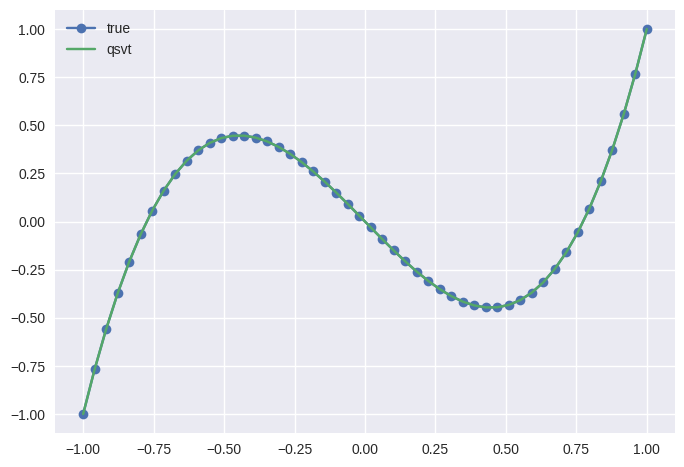

In [ ]:
x_vals = np.linspace(-1, 1, 50)

qsvt = [np.real(qsvt_output(x)) for x in x_vals]

plt.plot(x_vals, P(x_vals), '-o', label='true')
plt.plot(x_vals, qsvt, label='qsvt')
plt.legend()

With the above plot, we have successfully construct $P(x)$ using the QSVT function.

## Subsequent methods for finding the phases

As demonstrated in the implementation of the GSLW's method, we need to be careful of numerical instability arising from finite precision. Existing literature indicates that this issue imposes constraints on the maximum degree of polynomial that the GSLW's method can effectively handle. Nonetheless, this method holds substantial importance as it serves as the groundwork for notable improvements proposed in subsequent literature.


### 1. Haah's method
One notable follow-up work is Haah's method [[3]](#[3]).
Haah explored a variant of the GSLW's method using what's known as the Wz convention. In the equation we previously wrote, $$e^{i\phi_0 Z} \prod_{j=1}^{d} \left [ O(x) e^{i \phi_j Z}\right ] = \begin{bmatrix} P(x) & -Q(x) \sqrt{1-x^2} \\ Q^*(x) \sqrt{1-x^2} & P^*(x) \end{bmatrix},$$ the Wz convention refers to the resulting form when we multiply both sides of the equation $H e^{i\frac{\pi}{4}Z}$ from the left and $e^{-i\frac{\pi}{4}Z} H$ from the right:

$$ H e^{i\frac{\pi}{4}Z} \begin{bmatrix} P(x) & -Q(x) \sqrt{1-x^2} \\ Q^*(x) \sqrt{1-x^2} & P^*(x) \end{bmatrix} e^{-i\frac{\pi}{4}Z} H = \begin{bmatrix} F(w) & iG(w) \\ iG(w^{-1}) & F(w^{-1}) \end{bmatrix},$$

$$H e^{i\frac{\pi}{4}Z} U_{\Phi}(x) e^{-i\frac{\pi}{4}Z} H = e^{i \phi_0 X} \prod_{j=1}^{d} \left ( \begin{bmatrix} w & 0 \\ 0 & w^{-1} \end{bmatrix} e^{i \theta_j X} \right ).$$

Here, $w = e^{i \cos^{-1} x}$ (or $x = \frac{w+w^{-1}}{2}$) and $F(w), G(w) \in \mathbb{R}[w, w^{-1}]$ are Laurent polynomials. Further discussion regarding connections between different conventions is available in [[4, Appendix A]](#[4]).

A notable feature of the Wz convention is that the coefficients in the $F(w), G(w)$ are real numbers, whereas the coefficients in $P(x), Q(x)$ are complex numbers. This distinction could make the Wz convention advantageous for both analysis and computation. Under the Wz convention, Haah's approach inherits most of the ideas of completion and decomposition in the GSLW's method. Essentially, the first step involves finding roots of a Laurent polynomial to identify $G(w)$ given $F(w)$. The second step determines the phases by iteratively reducing the polynomial degree by one per iteration. These two features limit the number of classical bits required for precision $\epsilon$ to be on the order of $O \left ( d \log \frac{d}{\epsilon} \right )$.


### 2. CDGHS's method
To address the limitation in the decomposition step, Chao et al. [[5]](#[5]) proposed a method that involves "halving" of unitary matrices. Their first key insight was to depart from Haah's perspective, where $U(w) := \begin{bmatrix} F(w) & iG(w) \\ iG(w^{-1}) & F(w^{-1}) \end{bmatrix}$ is expressed as $\sum_{j=-d}^{d} C_j w^j$, with $C_j$ being either a zero matrix or in SU(2). Instead, they found it more convenient to consider $$U(w) = A(\tilde{w}) + B(\tilde{w}) \cdot iX$$ where $\tilde{w} = \begin{bmatrix} w & 0 \\ 0 & w^{-1} \end{bmatrix}$ and $A(\tilde{w}), B(\tilde{w})$ are Laurent polynomial of $\tilde{w}$. Chao et al. referred to matrices generated with $I$ and $X$ in this manner as "the Low algebra".

The term "halving" refers to the approach that, by solving a set of linear constraints in real numbers, it is possible to find a unitary matrix $V$ in Low algebra with degree $l$ such that $V^H U$ has a degree of $d-l$. Both $U, V$ and $V^H U$ must also have appropriate parities. This concept suggests a divide-and-conquer approach to decompose $U$ in the form $$U = V_1 V_2 V_3 \cdots.$$ By doing this, we can easily solve for the phases $\Phi$ when all $V_i$ have degrees of at most 1. Consequently, one of the potential reason that CDGHS's method is numerically more stable could be because the phases are only determined at the very end of the decomposition process.

### 3. Ying's method
More recently, Ying introduced a novel approach to enhance the completion step. The paper [[6]](#[6]) details this method in the so-called Wx convention and the polynomials are considered as a function of $w$. However, for consistency, we will describe his essential idea in the Wz convention.

In the Wz convention, the completion step involves finding $G(w)$, which is essentially the characterisitic polynomial $\prod_{j} (w - \xi_j)$ up to a multiplicative constant. Here, $\xi_j$ represents the roots of the polynomial $g(w) := 1 - F(w) F(w^{-1})$ that lie within the unit disk. While constructing the characteristic polynomial after solving for these roots is one appraoch, Ying pointed out that this route is not mandatory. Indeed, there is a convenient shortcut available, known as Prony's method, which has been used in signal processing for decades.

Prony's method says that if we have a sequence $(f_k)_{k \in \mathbb{Z}}$ of the form $$f_k = \sum_{j=1}^{d} r_j \lambda_j^k e^{i \theta_j k}$$ but the parameters $d, \lambda_j, \theta_j, r_j$ are unknown to us, it is possible to reconstruct a polynomial $m(z) = \prod_{j=1} (z - \lambda_j e^{i \theta_j})$ from the evaluation of $f_k$ at $2d+1$ consecutive values of $k$. In the context of QSP, we can consider $g(\theta)$ obtained by changing the variable in $g(w)$ through $w=e^{i\theta}$. After some calculations, it is possible to show that the Fourier transform of $1/g(\theta)$ takes the following form: $$\hat{g}_k := \frac{1}{2\pi} \int_{0}^{2\pi} \frac{1}{g(\theta)} e^{-ik\theta} d\theta = - \sum_{|\xi_j|<1} \hat{r}_j \xi_j^{-(k+1)}.$$ The integral can be approximated by the trapezoidal rule, making it efficient to obtain $\hat{g}_k$. If we then map $\hat{g}_k$ to $f_{k+1}$, it becomes straightforward to apply Prony's method to obtain the desired characteristic polynomial when the sequence $(\hat{g}_k)_{k=1, 2, \dots, 4d+1}$ is available.


### 4. Optimization-based method
All the methods mentioned above are based on polynomial factorization and recursion. In the pursuit of developing a numerically stable method for determining the phases in QSP, Dong et al. took a new direction based on optimization, as outlined in [[7]](#[7]). They demonstrated that when our primary goal is to encode $\text{Re}[P(x)] = f(x)$ with $\text{deg}(f) = d$ and considering parity, a specific efficient approach becomes viable. This approach involves carefully selecting a subset of $\tilde{d} = \lceil \frac{d+1}{2} \rceil$ points in the domain of $x$. The phases $\Phi$ are then solved by minimizing a cost function $$C(\Phi) := \frac{1}{\tilde{d}} \sum_{k=1}^{\tilde{d}} \left | \text{Re}[\bra{0} U_{\Phi}(x_k)\ket{0}] - f(x_k) \right |^2$$ over a specific parameter space with appropriate initialization. Importantly, the value of $\tilde{d}$ here is tight and significantly contributes to the efficiency of the optimization formulation.

In practice, if we do not have a tight constraint on the number of points $x_k$ on which we evaluate the functions, we can relax $\tilde{d}$ to a large number. This allows for less cautious consideration of technical details and enables a more straightforward function fitting approach using gradient descent methods available in typical machine learning tools.

## An open-source Python tool for QSP

With the state-of-the-art methods discussed above, researchers have already faciliated open-source implementations. As introduced in [[4]](#[4]), a Python package called `pyqsp` is available in [this GitHub repository](https://github.com/ichuang/pyqsp) for this purpose. It includes implementations of CDGHS's method and an optimization-based method using TensorFlow. Now, let's explore how to use this package to encode $P(x)$ in the example considered in the previous sections.

In [ ]:
!pip install git+https://github.com/ichuang/pyqsp.git

  Cloning https://github.com/ichuang/pyqsp.git to /tmp/pip-req-build-5w_4qv_g
  Running command git clone --filter=blob:none --quiet https://github.com/ichuang/pyqsp.git /tmp/pip-req-build-5w_4qv_g
  Resolved https://github.com/ichuang/pyqsp.git to commit 6ec2499c153b4359a11c914ff59bff16545508cc
  Preparing metadata (setup.py) ... done
  Created wheel for pyqsp: filename=pyqsp-0.1.6-py3-none-any.whl size=46170 sha256=d1329d31730faaf92b5257429d89700680fee62521cb9dee35e5a9293c395394
  Stored in directory: /tmp/pip-ephem-wheel-cache-lyry8awc/wheels/f6/22/34/147e57d39a8263d13c89cfc580cf4f08f376a9b1450eb3fe29
Successfully built pyqsp


In [ ]:
import pyqsp
import pyqsp.angle_sequence

phi_pyqsp = pyqsp.angle_sequence.QuantumSignalProcessingPhases(P_coef, signal_operator='Wx', tolerance=0.00001)

Once we have the phases in Wx convention, we can again use `qml.qsvt` in the matching convention.

In [ ]:
def qsvt_output_pyqsp(a):
  out = qml.matrix(qml.qsvt)(a, phi_pyqsp, wires=[0], convention='Wx')

  return out[0, 0]

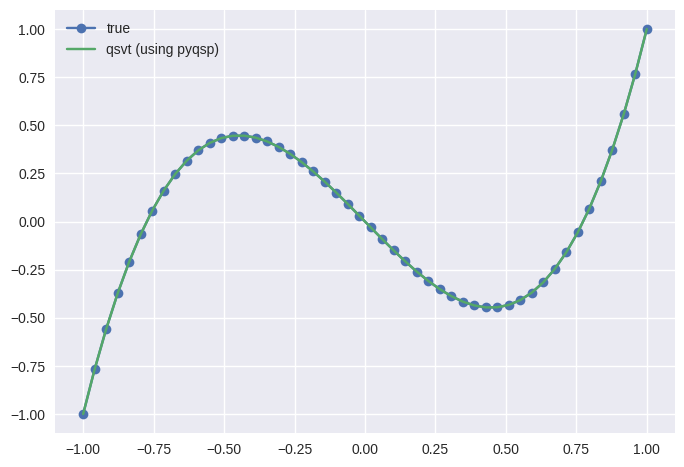

In [ ]:
qsvt = [np.real(qsvt_output_pyqsp(x)) for x in x_vals]

plt.plot(x_vals, P(x_vals), '-o', label='true')
plt.plot(x_vals, qsvt, label='qsvt (using pyqsp)')
plt.legend()

In [ ]:
q_script = qml.tape.QuantumScript(ops=[qml.qsvt(1., phi_pyqsp, wires=[0], convention='Wx')])
print(q_script.expand().expand().draw(decimals=2))

0: ──∏_ϕ(0.38)──BlockEncode(M0)──∏_ϕ(1.19)──BlockEncode(M0)†──∏_ϕ(1.19)──BlockEncode(M0)──∏_ϕ(1.95)

───RI(-3.14)─┤  
M0 = 
[[1.]]


As shown in the above pictures, the phases determined by `pyqsp` differ from the previous solution, yet the circuit still encodes $P(x)$. Indeed, the phases can have multiple valid solutions.

## Conclusion
In this notebook, we have provided an overview of the available methods for determining the phases in QSP at both the conceptual and implementation levels. It is interesting to observe how tools from complex analysis, Fourier analysis and signal processing can be harnessed to address this problem.

This notebook however does not cover methods for the same problem in a more realistic setting where quantum noise is present, which represents an ongoing area of research. Furthermore, a compelling question arises when we consider the relationship between QAOA and QSVT, given their structural similarities in parameterized circuits.

### References
<a id="references"></a>
<a id="[1]"></a>
1. L. Lin, [*Lecture Notes on Quantum Algorithms for Scientific Computation*](https://arxiv.org/abs/2201.08309), arXiv:2201.08309, 2022

<a id="[2]"></a>
2. A. Gilyén, Y. Su, G. H. Low, N. Wiebe, [*Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics*](https://arxiv.org/abs/1806.01838), ACM SIGACT Symposium on Theory of Computing, 2019

<a id="[3]"></a>
3. J. Haah, [*Product decomposition of periodic functions in quantum signal processing*](https://quantum-journal.org/papers/q-2019-10-07-190/), Quantum, 2019

<a id="[4]"></a>
4. J. M. Martyn, Z. M. Rossi, A. K. Tan, I. L. Chuang, [*A grand unification of quantum algorithm*](https://arxiv.org/abs/2105.02859), PRX Quantum, 2021

<a id="[5]"></a>
5. R. Chao, D. Ding, A. Gilyen, C. Huang, M. Szegedy, [*Finding angles for quantum signal processing with machine precision*](https://arxiv.org/abs/2003.02831), arXiv:2003.02831, 2020

<a id="[6]"></a>
6. L. Ying, [*Stable factorization for phase factors of quantum signal processing*](https://quantum-journal.org/papers/q-2022-10-20-842/), Quantum, 2022

<a id="[7]"></a>
7. Y. Dong, X. Meng, K. B. Whaley, and L. Lin, [*Efficient phase-factor evaluation in quantum signal processing*](https://arxiv.org/abs/2002.11649), Physical Review A, 2021